In [52]:
# 导入相关包
import os, json
from pathlib import Path
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from openai import OpenAI
import time


# 挂载 Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
def read_conll(path):
    """读取 CoNLL 格式文件，返回 [{'tokens': [...], 'ner_tags': [...]}]"""
    sents, tokens, labels = [], [], []
    with open(path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if tokens:
                    sents.append({"tokens": tokens, "ner_tags": labels})
                    tokens, labels = [], []
            else:
                parts = line.split()
                tok, lab = parts[0], parts[-1]
                tokens.append(tok)
                labels.append(lab)
    if tokens:
        sents.append({"tokens": tokens, "ner_tags": labels})
    return sents

def bio_to_medical_entities(tokens, tags):
    """从 BIO 标签中抽取医学实体列表"""
    entities = []
    i = 0
    while i < len(tags):
        if tags[i].startswith("B-"):
            j = i + 1
            while j < len(tags) and tags[j].startswith("I-"):
                j += 1
            entity = " ".join(tokens[i:j])
            entities.append(entity)
            i = j
        else:
            i += 1
    return entities

def build_fewshot_prompt_disease_GPT(train_path):
    """
    为 GPT 构造医学实体识别 Few-shot Prompt
    """
    train_data = read_conll(train_path)
    examples = train_data

    header = (
        "You are a medical information extraction assistant.\n"
        "Task: Extract all medical entities mentioned in each clinical sentence below.\n"
        "If no medical entity is found, output: Entity: None\n"
        "Output them strictly after 'Entity:' separated by semicolons.\n"
        "Do not add explanations or extra text.\n\n"
    )

    example_blocks = []
    for i, ex in enumerate(examples, 1):
        tokens = [t.strip() for t in ex["tokens"]]
        entities = bio_to_medical_entities(tokens, ex["ner_tags"])
        entities_str = "; ".join(entities) if entities else "None"
        block = (
            f"Example {i}:\n"
            f"Sentence: {' '.join(tokens)}\n"
            f"Entity: {entities_str}\n"
        )
        example_blocks.append(block)

    prompt = header + "\n---\n".join(example_blocks) + "\n\nNow analyze the following sentence:\nSentence: "
    return prompt


def build_fewshot_prompt_disease_T5(train_path):
    """
    为 Flan-T5 构造医学实体识别 Few-shot Prompt（优化版）
    """
    train_data = read_conll(train_path)
    examples = train_data

    header = (
        "Instruction: Extract all medical entities from the input sentence.\n"
        "If no medical entity is found, output: Entity: None\n"
        "Format the output as: Entity: entity1; entity2; ...\n\n"
    )

    example_blocks = []
    for i, ex in enumerate(examples, 1):
        tokens = [t.strip() for t in ex["tokens"]]
        entities = bio_to_medical_entities(tokens, ex["ner_tags"])
        entities_str = "; ".join(entities) if entities else "None"
        block = (
            f"Input: {' '.join(tokens)}\n"
            f"Target: Entity: {entities_str}\n"
        )
        example_blocks.append(block)

    prompt = header + "\n---\n".join(example_blocks) + "\n\nInput: "
    return prompt

In [54]:
train_path = "/content/drive/MyDrive/small_data_NER_project/conll/fewshot_k1_seed42_mention/train.conll"

prompt_text = build_fewshot_prompt_disease_GPT(train_path)

print("==== 以下是为 ChatGPT 构造的医学实体识别 Few-Shot 示例 ====\n")
print(prompt_text)


prompt_text = build_fewshot_prompt_disease_T5(train_path)

print("==== 以下是为 Flan-T5 构造的医学实体识别 Few-Shot 示例 ====\n")
print(prompt_text)


==== 以下是为 ChatGPT 构造的医学实体识别 Few-Shot 示例 ====

You are a medical information extraction assistant.
Task: Extract all medical entities mentioned in each clinical sentence below.
If no medical entity is found, output: Entity: None
Output them strictly after 'Entity:' separated by semicolons.
Do not add explanations or extra text.

Example 1:
Sentence: Coronary angiography done demonstrated significant lesions in the mid portion of the Left Descending Coronary Artery ( LAD ) and the proximal Circumflex Coronary Artery ( Cx ) .
Entity: lesions in the mid portion of the Left Descending Coronary Artery


Now analyze the following sentence:
Sentence: 
==== 以下是为 Flan-T5 构造的医学实体识别 Few-Shot 示例 ====

Instruction: Extract all medical entities from the input sentence.
If no medical entity is found, output: Entity: None
Format the output as: Entity: entity1; entity2; ...

Input: Coronary angiography done demonstrated significant lesions in the mid portion of the Left Descending Coronary Artery ( LAD 

In [55]:
# --- 推理函数 ---
def predict_flan_t5(prompt_prefix, sentence):
    full_prompt = prompt_prefix + sentence
    inputs = t5_tokenizer(full_prompt, return_tensors="pt", truncation=True)
    outputs = t5_model.generate(**inputs, max_new_tokens=50)
    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

def predict_gpt(prompt_prefix, sentence):
    full_prompt = prompt_prefix + sentence
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a medical information extraction assistant."},
            {"role": "user", "content": full_prompt},
        ],
        temperature=0
    )
    return response.choices[0].message.content

In [56]:
# --- F1 计算函数 ---
def compute_f1(pred_entities, gold_entities):
    correct = sum(len(set(p) & set(g)) for p, g in zip(pred_entities, gold_entities))
    total_pred = sum(len(p) for p in pred_entities)
    total_gold = sum(len(g) for g in gold_entities)
    prec = correct / total_pred if total_pred else 0
    rec = correct / total_gold if total_gold else 0
    f1 = 2 * prec * rec / (prec + rec + 1e-10)
    return prec, rec, f1

In [57]:
# --- 模型加载（Flan-T5） ---
t5_name = "google/flan-t5-base"
t5_tokenizer = AutoTokenizer.from_pretrained(t5_name)
t5_model = AutoModelForSeq2SeqLM.from_pretrained(t5_name)

In [ ]:
# --- 设置 GPT API Key ---
import os
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = input("Enter your OpenAI API key: ")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [60]:
# 设置路径
BASE = Path("/content/drive/MyDrive/small_data_NER_project/conll")
RESULT_BASE = Path("/content/drive/MyDrive/small_data_NER_project/results")
K_VALUES = [1,5,10,20]
SEED = 42

In [61]:
# --- 主循环 ---
for k in K_VALUES:
    print(f"\n=== Few-shot k={k} ===")
    data_dir = BASE / f"fewshot_k{k}_seed{SEED}_mention"
    train_path, test_path = data_dir / "train.conll", data_dir / "test.conll"
    test_data = read_conll(test_path)

    # 构造 prompts
    prompt_t5 = build_fewshot_prompt_disease_T5(train_path)
    prompt_gpt = build_fewshot_prompt_disease_GPT(train_path)

    for model_type in ["flan-t5", "gpt-4o-mini"]:
        print(f"\n--- Evaluating {model_type} ---")
        preds, golds = [], []

        # 🕒 开始计时
        t0 = time.time()

        for ex in tqdm(test_data):
            sent = " ".join(ex["tokens"])
            if model_type == "flan-t5":
                out = predict_flan_t5(prompt_t5, sent)
            else:
                out = predict_gpt(prompt_gpt, sent)

            out = out.replace("Entity:", "").strip()
            ents_pred = [x.strip() for x in out.split(";") if x.strip() and x.lower() != "none"]
            ents_gold = bio_to_medical_entities(ex["tokens"], ex["ner_tags"])
            preds.append(ents_pred)
            golds.append(ents_gold)

        # 🕒 结束计时
        infer_time = time.time() - t0
        print(f"Inference time: {infer_time:.2f} seconds")

        # 计算指标
        p, r, f1 = compute_f1(preds, golds)
        print(f"Precision={p:.3f} Recall={r:.3f} F1={f1:.3f}")

        # 🧠 记录资源使用
        import torch, psutil
        gpu_mem_mb = torch.cuda.max_memory_allocated() / (1024 * 1024) if torch.cuda.is_available() else 0
        mem_info = psutil.virtual_memory()
        used_mem_gb = mem_info.used / (1024**3)
        mem_percent = mem_info.percent

        print(f"💾 GPU peak memory: {gpu_mem_mb:.1f} MB | CPU memory used: {used_mem_gb:.1f} GB ({mem_percent:.1f}%)")

        # 保存结果
        out_dir = RESULT_BASE / f"prompt_{model_type}_k{k}"
        out_dir.mkdir(parents=True, exist_ok=True)
        results = {
            "k": k,
            "model": model_type,
            "precision": p,
            "recall": r,
            "f1": f1,
            "infer_time_s": infer_time,
            "gpu_mem_mb": gpu_mem_mb,
            "cpu_mem_gb": used_mem_gb,
            "cpu_mem_percent": mem_percent
        }
        with open(out_dir / "metrics.json", "w") as f:
            json.dump(results, f, indent=2)
        print(f"✅ Saved to {out_dir}/metrics.json")



=== Few-shot k=1 ===

--- Evaluating flan-t5 ---


100%|██████████| 851/851 [17:54<00:00,  1.26s/it]


Inference time: 1074.43 seconds
Precision=0.037 Recall=0.033 F1=0.035
Precision=0.037 Recall=0.033 F1=0.035
💾 GPU peak memory: 0.0 MB | CPU memory used: 4.7 GB (39.9%)
✅ Saved to /content/drive/MyDrive/small_data_NER_project/results/prompt_flan-t5_k1/metrics.json

--- Evaluating gpt-4o-mini ---


100%|██████████| 851/851 [08:46<00:00,  1.62it/s]

Inference time: 526.13 seconds
Precision=0.157 Recall=0.713 F1=0.258
Precision=0.157 Recall=0.713 F1=0.258
💾 GPU peak memory: 0.0 MB | CPU memory used: 4.7 GB (39.8%)
✅ Saved to /content/drive/MyDrive/small_data_NER_project/results/prompt_gpt-4o-mini_k1/metrics.json



Summary of results:
         model  k        f1  precision    recall  infer_time_s
0      flan-t5  1  0.034765   0.036797  0.032946   1074.427388
1  gpt-4o-mini  1  0.257884   0.157399  0.713178    526.125991
✅ Saved summary to /content/drive/MyDrive/small_data_NER_project/results/results_summary.csv


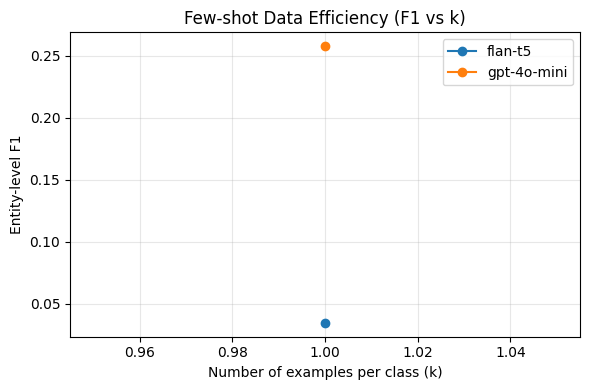

In [62]:
import json
import pandas as pd
import matplotlib.pyplot as plt

summary = []

# 读取所有结果
for model_type in ["flan-t5", "gpt-4o-mini"]:
    for k in K_VALUES:
        out_dir = RESULT_BASE / f"prompt_{model_type}_k{k}" / "metrics.json"
        if out_dir.exists():
            with open(out_dir, "r") as f:
                data = json.load(f)
                data["model"] = model_type
                summary.append(data)
        else:
            print(f"⚠️ Missing file: {out_dir}")

# 汇总成 DataFrame
df = pd.DataFrame(summary)
df = df.sort_values(by=["model", "k"])
print("\nSummary of results:")
print(df[["model", "k", "f1", "precision", "recall", "infer_time_s"]])

# 保存 CSV
summary_csv = RESULT_BASE / "results_summary.csv"
df.to_csv(summary_csv, index=False)
print(f"✅ Saved summary to {summary_csv}")

# --- 画 F1 vs k ---
plt.figure(figsize=(6,4))
for model in df["model"].unique():
    sub = df[df["model"] == model]
    plt.plot(sub["k"], sub["f1"], marker="o", label=model)

plt.title("Few-shot Data Efficiency (F1 vs k)")
plt.xlabel("Number of examples per class (k)")
plt.ylabel("Entity-level F1")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
